In [1]:
#dataframes
import pandas as pd
import h5py

#speedup
import multiprocessing as mp

#suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.TimeSeries = pd.Series 

#math
import numpy as np
from scipy.spatial.distance import cdist
from scipy import signal
import math
import copy


#plots
import pylab as plt
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import matplotlib
from figurefirst import FigureLayout,mpl_functions
import figurefirst
import matplotlib.image as mpimg
from mpl_toolkits.axes_grid1 import make_axes_locatable # for colorbar
import seaborn as sns
sns.set()
sns.set_style("whitegrid")
import figurefirst as fifi
from IPython.display import display,SVG

#misc
import cairosvg
import itertools
import time
np.set_printoptions(suppress=True)

FS=7

In [2]:
def __kalman_forward_update__(xhat_fm, P_fm, y, u, A, B, C, R, Q):
    """
    :param xhat_fm:
    :param P_fm:
    :param y:
    :param u:
    :param A:
    :param B:
    :param C:
    :param R:
    :param Q:
    :return:
    """
    
    
    I = np.array(np.eye(A.shape[0]))
    gammaW = np.array(np.eye(A.shape[0]))

    K_f = P_fm@C.T@np.linalg.pinv(C@P_fm@C.T + R)

    if y is not None:
        new_info = (y - C@xhat_fm)
        new_info[np.isnan(new_info)] = 0
        xhat_fp = xhat_fm + K_f@new_info
        
        P_fp = (I - K_f@C)@P_fm
        xhat_fm = A@xhat_fp + B@u
        P_fm = A@P_fp@A.T + gammaW@Q@gammaW.T
        
    return xhat_fp, xhat_fm, P_fp, P_fm


def __kalman_forward_filter__(xhat_fm, P_fm, y, u, A, B, C, R, Q):
    """
    :param xhat_fm:
    :param P_fm:
    :param y:
    :param u:
    :param A:
    :param B:
    :param C:
    :param R:
    :param Q:
    :return:
    """
    if u is None:
        u = np.array(np.zeros([B.shape[1], y.shape[1]]))

    xhat_fp = None
    P_fp = []
    P_fm = [P_fm]

    for i in range(y.shape[1]):
        _xhat_fp, _xhat_fm, _P_fp, _P_fm = __kalman_forward_update__(xhat_fm[:, [-1]], P_fm[-1], y[:, [i]], u[:, [i]],
                                                                     A, B, C, R, Q)
        
        if xhat_fp is None:
            xhat_fp = _xhat_fp
        else:
            xhat_fp = np.hstack((xhat_fp, _xhat_fp))
        xhat_fm = np.hstack((xhat_fm, _xhat_fm))

        P_fp.append(_P_fp)
        P_fm.append(_P_fm)

    return xhat_fp, xhat_fm, P_fp, P_fm


def __kalman_backward_smooth__(xhat_fp, xhat_fm, P_fp, P_fm, A):
    """
    :param xhat_fp:
    :param xhat_fm:
    :param P_fp:
    :param P_fm:
    :param A:
    :return:
    """
    N = xhat_fp.shape[1]

    xhat_smooth = copy.copy(xhat_fp)
    P_smooth = copy.copy(P_fp)
    for t in range(N-2, -1, -1):
        L = P_fp[t]@A.T@np.linalg.pinv(P_fm[t])
        xhat_smooth[:, [t]] = xhat_fp[:, [t]] + L@(xhat_smooth[:, [t+1]] - xhat_fm[:, [t+1]])
        P_smooth[t] = P_fp[t] - L@(P_smooth[t+1] - P_fm[t+1])

    return xhat_smooth, P_smooth


def klm_cal(data1,data2):
    wind_vector = np.vstack((data_2.U.values, data_2.V.values)).T
    wind_magnitude = np.linalg.norm(wind_vector, axis=1)
    unit_wind_vector = wind_vector / np.vstack((wind_magnitude, wind_magnitude)).T


    velocity_vector = np.vstack((data_2.ground_speed_x.values, data_2.ground_speed_y.values)).T

    # There is probably a more efficient syntax
    velocity_ground_relative_to_wind = [np.dot(velocity_vector[i,:], unit_wind_vector[i,:]) for i in range(len(velocity_vector))]

    data_for_kf_original = pd.DataFrame({'time': data_2.time, 
                                    'velocity_ground_relative_to_wind': velocity_ground_relative_to_wind,
                                    'distance_true': data_2.distance_from_source,
                                    'distance_odor_observed': np.nan*np.ones_like(velocity_ground_relative_to_wind)})
    # kalman filter is slow, let's subsample the data
    data_for_kf = copy.copy( data_for_kf_original[::20] )
    # put distance from odor predictions in the right places
    for ix_odor in data_1.index:
        ix_kf = np.argmin( np.abs(data_1.mean_whiff_time[ix_odor] - data_for_kf.time))
        data_for_kf.distance_odor_observed.iloc[ix_kf] = data_1.predicted_distance.loc[ix_odor]
    #     print(data_for_kf.distance_odor_observed[ix_kf])

    dt = np.median(np.diff(data_for_kf.time.values))
    y = np.array([data_for_kf.distance_odor_observed.values, 
                  data_for_kf.velocity_ground_relative_to_wind.values])

    ### Define dynamics: assume constant velocity

    # constant velocity
    A = np.array([[1, dt], [0, 1]])

    # no explicit control inputs
    B = np.array([[0], [0]])

    # we have measurements of distance and velocity
    C = np.array([[1, 0], [0, 1]])


    ### Define covariances
    # measurement covariances: the measurements of the observed distance are worse than the velocity measurements
    R = np.array([[1e-1, 0], [0, 1e-3]])
    # R = np.array([[1e-2, 0], [0, 1e-3]]) #Forest

    # model covariances: the model for constant velocity is probably worse than the model for distance = integral of velocity
    Q = np.array([[1e-3, 0], [0, 1e-1]])
    # Q = np.array([[1e-2, 0], [0, 1]]) #Forest

    ### Define initial conditions
    x0 = np.array([[0], [0]])
    P0 = np.array(100*np.eye(2))
    u = None # control input -- technically this could be the acceleration, but not needed

    ### Choose a subset of the measurements for testing
    ix_start = 0
    ix_end = 100000

    y_subset = copy.copy( y[:, ix_start:ix_end] )
    y_subset[0,0] = 5 # start with a guess for initial distance (can't be nan)

    time = data_for_kf.time[ix_start:ix_end].values

    ### Run the filter and smoother
    xhat_fp, xhat_fm, P_fp, P_fm = __kalman_forward_filter__(x0, P0, y_subset, u, A, B, C, R, Q)
    xhat_smooth, _ = __kalman_backward_smooth__(xhat_fp, xhat_fm, P_fp, P_fm, A)
    return xhat_smooth, time, data_for_kf

def klm_cal_forest(data1,data2):
    wind_vector = np.vstack((data_2.U.values, data_2.V.values)).T
    wind_magnitude = np.linalg.norm(wind_vector, axis=1)
    unit_wind_vector = wind_vector / np.vstack((wind_magnitude, wind_magnitude)).T


    velocity_vector = np.vstack((data_2.ground_speed_x.values, data_2.ground_speed_y.values)).T

    # There is probably a more efficient syntax
    velocity_ground_relative_to_wind = [np.dot(velocity_vector[i,:], unit_wind_vector[i,:]) for i in range(len(velocity_vector))]

    data_for_kf_original = pd.DataFrame({'time': data_2.time, 
                                    'velocity_ground_relative_to_wind': velocity_ground_relative_to_wind,
                                    'distance_true': data_2.distance_from_source,
                                    'distance_odor_observed': np.nan*np.ones_like(velocity_ground_relative_to_wind)})
    # kalman filter is slow, let's subsample the data
    data_for_kf = copy.copy( data_for_kf_original[::20] )
    # put distance from odor predictions in the right places
    for ix_odor in data_1.index:
        ix_kf = np.argmin( np.abs(data_1.mean_whiff_time[ix_odor] - data_for_kf.time))
        data_for_kf.distance_odor_observed.iloc[ix_kf] = data_1.predicted_distance.loc[ix_odor]
    #     print(data_for_kf.distance_odor_observed[ix_kf])

    dt = np.median(np.diff(data_for_kf.time.values))
    y = np.array([data_for_kf.distance_odor_observed.values, 
                  data_for_kf.velocity_ground_relative_to_wind.values])

    ### Define dynamics: assume constant velocity

    # constant velocity
    A = np.array([[1, dt], [0, 1]])

    # no explicit control inputs
    B = np.array([[0], [0]])

    # we have measurements of distance and velocity
    C = np.array([[1, 0], [0, 1]])


    ### Define covariances
    # measurement covariances: the measurements of the observed distance are worse than the velocity measurements
    R = np.array([[1e-2, 0], [0, 1e-3]]) #Forest

    # model covariances: the model for constant velocity is probably worse than the model for distance = integral of velocity
    Q = np.array([[1e-2, 0], [0, 1]]) #Forest

    ### Define initial conditions
    x0 = np.array([[0], [0]])
    P0 = np.array(100*np.eye(2))
    u = None # control input -- technically this could be the acceleration, but not needed

    ### Choose a subset of the measurements for testing
    ix_start = 0
    ix_end = 100000

    y_subset = copy.copy( y[:, ix_start:ix_end] )
    y_subset[0,0] = 5 # start with a guess for initial distance (can't be nan)

    time = data_for_kf.time[ix_start:ix_end].values

    ### Run the filter and smoother
    xhat_fp, xhat_fm, P_fp, P_fm = __kalman_forward_filter__(x0, P0, y_subset, u, A, B, C, R, Q)
    xhat_smooth, _ = __kalman_backward_smooth__(xhat_fp, xhat_fm, P_fp, P_fm, A)
    return xhat_smooth, time, data_for_kf

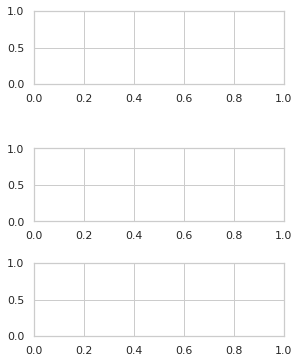

In [3]:
layout = fifi.svg_to_axes.FigureLayout('../../../../Figure/klmsupplmental.svg',
                                           autogenlayers=True, make_mplfigures=True, hide_layers=[])

## HWS

In [4]:
dir='~/DataAnalysis/data/Sprints/HighRes/KF/'
data_1=pd.read_hdf(dir+'AllPredictions.h5')
data_2=pd.read_hdf(dir+'WindyMASigned.h5')

In [5]:
xhat_smooth,time,data_for_kf = klm_cal(data_1,data_2)

ax=layout.axes[('fig','a1')]
ax.grid(False)
line_width=0.5
marker_size=0.5
ax.plot(data_1.mean_whiff_time, data_1.predicted_distance, '.', 
        color='black', label='Predicted Distance',linewidth=line_width,
        markersize=marker_size*2,
        rasterized= True)
ax.plot(time, xhat_smooth[0,:], color='black', label='Smoothed Distance', 
        linewidth=line_width,markersize=marker_size,
        rasterized= True)
ax.plot(data_for_kf.time, data_for_kf.distance_true, '--', color='red',
        label='True Distance',linewidth=line_width, markersize=marker_size,rasterized= True)

ax.set_rasterization_zorder(-20)
ax.set_xlim(1000, 2000)

mpl_functions.adjust_spines(ax,['left'],
                            spine_locations={'left':4,'bottom':4},
                            smart_bounds=True,
                            yticks=[-10,70],
                            xticks=[1000,2000],
                            linewidth=0.5)

ax.set_xticklabels([])
ax.set_ylabel('Distance, m')
ax.yaxis.set_label_coords(-0.04, 0.5)


figurefirst.mpl_functions.set_fontsize(ax, FS)
layout.append_figure_to_layer(layout.figures['fig'], 'fig', cleartarget=True)
layout.write_svg('../../../../Figure/klmsupplmental.svg')

In [6]:
dir='~/DataAnalysis/data/Sprints/HighRes/KF/'
data_1=pd.read_hdf(dir+'WindyPredictions.h5')
data_2=pd.read_hdf(dir+'WindyMASigned.h5')

In [7]:
xhat_smooth,time,data_for_kf = klm_cal(data_1,data_2)

ax=layout.axes[('fig','a1')]
ax.grid(False)
line_width=0.8
marker_size=0.5

ax.plot(time, xhat_smooth[0,:], color='g', label='Smoothed Distance', 
        linewidth=line_width,markersize=marker_size,
        rasterized= True)

ax.set_rasterization_zorder(-20)
ax.set_xlim(1000, 2000)

mpl_functions.adjust_spines(ax,['left'],
                            spine_locations={'left':4,'bottom':4},
                            smart_bounds=True,
                            yticks=[-10,70],
                            xticks=[1000,2000],
                            linewidth=0.5)

ax.set_xticklabels([])
ax.set_ylabel('Distance, m')
ax.yaxis.set_label_coords(-0.04, 0.5)


figurefirst.mpl_functions.set_fontsize(ax, FS)
layout.append_figure_to_layer(layout.figures['fig'], 'fig', cleartarget=True)
layout.write_svg('../../../../Figure/klmsupplmental.svg')

## LWS

In [8]:
dir='~/DataAnalysis/data/Sprints/HighRes/KF/'
data_1=pd.read_hdf(dir+'AllPredictions.h5')
data_2=pd.read_hdf(dir+'NotWindyMASigned.h5')

In [9]:
xhat_smooth,time,data_for_kf = klm_cal(data_1,data_2)

ax=layout.axes[('fig','a2')]
ax.grid(False)
line_width=0.5
marker_size=0.5
ax.plot(data_1.mean_whiff_time, data_1.predicted_distance, '.', 
        color='black', label='Predicted Distance',linewidth=line_width,
        markersize=marker_size*2,
        rasterized= True)
ax.plot(time, xhat_smooth[0,:], color='black', label='Smoothed Distance', 
        linewidth=line_width,markersize=marker_size,
        rasterized= True)
ax.plot(data_for_kf.time, data_for_kf.distance_true, '--', color='red',
        label='True Distance',linewidth=line_width, markersize=marker_size,rasterized= True)

ax.set_rasterization_zorder(-20)
ax.set_xlim(1500,2500)
ax.set_ylim(-10,70)

mpl_functions.adjust_spines(ax,['left'],
                            spine_locations={'left':4},
                            smart_bounds=True,
                            yticks=[-10,70],
                            xticks=[2000,3000],
                            linewidth=0.5)
ax.set_xticklabels([], rotation=90)
ax.set_ylabel('Distance, m')
ax.yaxis.set_label_coords(-0.04, 0.5)

figurefirst.mpl_functions.set_fontsize(ax, FS)
layout.append_figure_to_layer(layout.figures['fig'], 'fig', cleartarget=True)
layout.write_svg('../../../../Figure/klmsupplmental.svg')

In [11]:
dir='~/DataAnalysis/data/Sprints/HighRes/KF/'
data_1=pd.read_hdf(dir+'NotWindyPredictions.h5')
data_2=pd.read_hdf(dir+'NotWindyMASigned.h5')

In [12]:
xhat_smooth,time,data_for_kf = klm_cal(data_1,data_2)


ax=layout.axes[('fig','a2')]
ax.grid(False)
line_width=0.8
marker_size=0.5

ax.plot(time, xhat_smooth[0,:], color='g', label='Smoothed Distance', 
        linewidth=line_width,markersize=marker_size,
        rasterized= True)

ax.set_rasterization_zorder(-20)
ax.set_xlim(1500,2500)
ax.set_ylim(-10,70)

mpl_functions.adjust_spines(ax,['left'],
                            spine_locations={'left':4},
                            smart_bounds=True,
                            yticks=[-10,70],
                            xticks=[2000,3000],
                            linewidth=0.5)
ax.set_xticklabels([], rotation=90)
ax.set_ylabel('Distance, m')
ax.yaxis.set_label_coords(-0.04, 0.5)

figurefirst.mpl_functions.set_fontsize(ax, FS)
layout.append_figure_to_layer(layout.figures['fig'], 'fig', cleartarget=True)
layout.write_svg('../../../../Figure/klmsupplmental.svg')

## Forest

In [13]:
dir='~/DataAnalysis/data/Sprints/HighRes/KF/'
data_1=pd.read_hdf(dir+'AllPredictions.h5')
data_2=pd.read_hdf(dir+'ForestMASigned.h5')

In [14]:
xhat_smooth,time,data_for_kf = klm_cal_forest(data_1,data_2)

ax=layout.axes[('fig','a3')]
ax.grid(False)
line_width=0.5
marker_size=0.5
ax.plot(data_1.mean_whiff_time, data_1.predicted_distance, '.', 
        color='black', label='Predicted Distance',linewidth=line_width,
        markersize=marker_size*2,
        rasterized= True)
ax.plot(time, xhat_smooth[0,:], color='black', label='Smoothed Distance', 
        linewidth=line_width,markersize=marker_size,
        rasterized= True)
ax.plot(data_for_kf.time, data_for_kf.distance_true, '--', color='red',
        label='True Distance',linewidth=line_width, markersize=marker_size,rasterized= True)

ax.set_rasterization_zorder(-20)
ax.set_ylim(-10,70)
ax.set_xlim(1000,2000)
mpl_functions.adjust_spines(ax,['left','bottom'],
                            spine_locations={'left':4,'bottom':6},
                            smart_bounds=True,
                            yticks=[-10,70],
                            xticks=[1000,2000],
                            linewidth=0.5)
ax.set_xticklabels([], rotation=90)


ax.set_xlabel('1000 secs')
ax.xaxis.set_label_coords(0.5, -0.1)
ax.set_ylabel('Distance, m')
ax.yaxis.set_label_coords(-0.04, 0.5)


figurefirst.mpl_functions.set_fontsize(ax, FS)
layout.append_figure_to_layer(layout.figures['fig'], 'fig', cleartarget=True)
layout.write_svg('../../../../Figure/klmsupplmental.svg')

In [15]:
dir='~/DataAnalysis/data/Sprints/HighRes/KF/'
data_1=pd.read_hdf(dir+'ForestPredictions.h5')
data_2=pd.read_hdf(dir+'ForestMASigned.h5')

In [16]:
xhat_smooth,time,data_for_kf = klm_cal_forest(data_1,data_2)


ax=layout.axes[('fig','a3')]
ax.grid(False)
line_width=0.8

ax.plot(time, xhat_smooth[0,:], color='g', label='Smoothed Distance', 
        linewidth=line_width,markersize=marker_size,
        rasterized= True)

ax.set_rasterization_zorder(-20)
ax.set_ylim(-10,70)
ax.set_xlim(1000,2000)
mpl_functions.adjust_spines(ax,['left','bottom'],
                            spine_locations={'left':4,'bottom':6},
                            smart_bounds=True,
                            yticks=[-10,70],
                            xticks=[1000,2000],
                            linewidth=0.5)
ax.set_xticklabels([], rotation=90)


ax.set_xlabel('1000 secs')
ax.xaxis.set_label_coords(0.5, -0.1)
ax.set_ylabel('Distance, m')
ax.yaxis.set_label_coords(-0.04, 0.5)


figurefirst.mpl_functions.set_fontsize(ax, FS)
layout.append_figure_to_layer(layout.figures['fig'], 'fig', cleartarget=True)
layout.write_svg('../../../../Figure/klmsupplmental.svg')